# Flower Recognition Project 
*PyTorch & Computer Vision for AI Engineering Master with ProfessionAI*

## Google Colab configuration

If you're testing this project on Google Colab, it could be useful for you to run the following cells

In [ ]:
# If you are running this code on Google Colab, run this:

!git clone https://github.com/Silvano315/Flower-Recognition-and-Detection-with-PyTorch.git

%cd Flower-Recognition-and-Detection-with-PyTorch
%pwd

In [ ]:
# Extract dataset from Google Drive (dataset folder or zip file)

from google.colab import drive
drive.mount('/content/drive')

#!cp -r /content/drive/MyDrive/Project_PyTorch_ProfessionAI/dataset_flower/ /content/Flower-Recognition-and-Detection-with-PyTorch/

#from src.utils import extract_dataset
#extract_dataset("/content/drive/MyDrive/Project_PyTorch_ProfessionAI/progetto-finale-flowes.tar.gz", 
#                'dataset')

In [1]:
# Second option: extract dataset from url or from a local folder

from src.utils import extract_dataset

extract_dataset("https://proai-datasets.s3.eu-west-3.amazonaws.com/progetto-finale-flowes.tar.gz", 
                'dataset')

/Users/silvanoquarto/Desktop/PROJECTS/Master_AI_Engineering/Flower-Recognition-and-Detection-with-PyTorch/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Downloading: 100%|██████████| 63.2M/63.2M [00:09<00:00, 6.49MiB/s]
Extracting files: 100%|██████████| 3674/3674 [00:00<00:00, 5985.28file/s]


Dataset extracted to prova
Total files extracted: 3674
Removing macOS hidden files...
Removed 1841 macOS hidden files/folders
Final number of files: 1833


## Import Libraries and initial Set-Up

In [1]:
# Import libraries

import os
import random
import logging
import time
import torch

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from torchsummary import summary

from src.constants import RANDOM_SEED, DATA_PATH, BATCH_SIZE
from src.utils import extract_dataset, get_paths_to_files, get_dataset_paths, get_logger
from src.visualization import display_random_images, visualize_class_samples, plot_class_distribution, compare_class_distribution, \
                        analyze_image_dimensions, analyze_color_distribution, visualize_random_images, visualize_augmented_images, \
                        scatter_plot_metrics, plot_confusion_matrix, generate_interactive_report
from src.preprocessing import create_datasets, create_data_loaders
from src.models import create_model, Experiment, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, train_model, validate, \
                        get_predictions, freeze_layers, plot_misclassified_images

/Users/silvanoquarto/Desktop/PROJECTS/Master_AI_Engineering/Flower-Recognition-and-Detection-with-PyTorch/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/silvanoquarto/Desktop/PROJECTS/Master_AI_Engineering/Flower-Recognition-and-Detection-with-PyTorch/.venv/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.19 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Set Random Seed for reproducibility

os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
# Check if GPU is available and set it as device 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"This repository is connected to {str(device).upper()}")

This repository is connected to CPU


## Extract zipped Dataset

In [4]:
# Extract Dataset and save files to dataset folder

extract_dataset('progetto-finale-flowes.tar.gz', 'dataset/')

Extracting files: 100%|██████████| 3674/3674 [00:00<00:00, 5980.24file/s]


Dataset extracted to dataset
Total files extracted: 3674
Removing macOS hidden files...
Removed 1841 macOS hidden files/folders
Final number of files: 1833


## Exploratory Data Analysis

In [5]:
# Get paths and filenames form directory dataset 

filepaths, filenames = get_paths_to_files(DATA_PATH)

print("="*80)
print("File paths:")
for i in range(0,5):
    print(filepaths[i])
print("="*80)
print("File names:")
for i in range(0,5):
    print(filenames[i])
print("="*80)

File paths:
dataset/progetto-finale-flowes/train/daisy/1879567877_8ed2a5faa7_n_jpg.rf.38fa4a22817b8f3b37f50d22ea608f96.jpg
dataset/progetto-finale-flowes/train/daisy/7702332000_3f21ef4571_n_jpg.rf.938ac8ed1d43f09d9566cdd327339ddc.jpg
dataset/progetto-finale-flowes/train/daisy/2454280137_e1637536ae_n_jpg.rf.f7b21fb60a95a578b5c4f1a880fa1887.jpg
dataset/progetto-finale-flowes/train/daisy/12701063955_4840594ea6_n_jpg.rf.058be03c02d95624d8c201fe3eedb333.jpg
dataset/progetto-finale-flowes/train/daisy/7630517248_98fb8bee1f_n_jpg.rf.3fa9ef879de7039bf2c346681d49e6e8.jpg
File names:
1879567877_8ed2a5faa7_n_jpg.rf.38fa4a22817b8f3b37f50d22ea608f96.jpg
7702332000_3f21ef4571_n_jpg.rf.938ac8ed1d43f09d9566cdd327339ddc.jpg
2454280137_e1637536ae_n_jpg.rf.f7b21fb60a95a578b5c4f1a880fa1887.jpg
12701063955_4840594ea6_n_jpg.rf.058be03c02d95624d8c201fe3eedb333.jpg
7630517248_98fb8bee1f_n_jpg.rf.3fa9ef879de7039bf2c346681d49e6e8.jpg


In [6]:
# Access to path dirs and file names for each split (test, train, val)

dataset_paths = get_dataset_paths(DATA_PATH)

train_paths, train_names = dataset_paths['train']
test_paths, test_names = dataset_paths['test']
val_paths, val_names = dataset_paths['valid']

print("="*80)
print("File paths:")
for i in range(0,5):
    print(train_paths[i])
print("="*80)
print("File names:")
for i in range(0,5):
    print(train_names[i])
print("="*80)

File paths:
dataset/progetto-finale-flowes/train/daisy/1879567877_8ed2a5faa7_n_jpg.rf.38fa4a22817b8f3b37f50d22ea608f96.jpg
dataset/progetto-finale-flowes/train/daisy/7702332000_3f21ef4571_n_jpg.rf.938ac8ed1d43f09d9566cdd327339ddc.jpg
dataset/progetto-finale-flowes/train/daisy/2454280137_e1637536ae_n_jpg.rf.f7b21fb60a95a578b5c4f1a880fa1887.jpg
dataset/progetto-finale-flowes/train/daisy/12701063955_4840594ea6_n_jpg.rf.058be03c02d95624d8c201fe3eedb333.jpg
dataset/progetto-finale-flowes/train/daisy/7630517248_98fb8bee1f_n_jpg.rf.3fa9ef879de7039bf2c346681d49e6e8.jpg
File names:
1879567877_8ed2a5faa7_n_jpg.rf.38fa4a22817b8f3b37f50d22ea608f96.jpg
7702332000_3f21ef4571_n_jpg.rf.938ac8ed1d43f09d9566cdd327339ddc.jpg
2454280137_e1637536ae_n_jpg.rf.f7b21fb60a95a578b5c4f1a880fa1887.jpg
12701063955_4840594ea6_n_jpg.rf.058be03c02d95624d8c201fe3eedb333.jpg
7630517248_98fb8bee1f_n_jpg.rf.3fa9ef879de7039bf2c346681d49e6e8.jpg


In [ ]:
# Visualize n random images 

fig, axes = display_random_images(filepaths, n=25)
plt.show() 

In [ ]:
# Visualize n random images from a chosen split dataset (train_paths, test_paths, val_paths)

chosen_split = train_paths

fig, axes = display_random_images(chosen_split, n=25)
plt.show() 

In [ ]:
# Displays sample images for each class in the chosen split set

chosen_split = train_paths

fig = visualize_class_samples(chosen_split, num_samples=3, max_classes=2)
plt.show()

In [ ]:
# Bar plot for class distribution for each dataset split

chosen_split = train_paths

class_dist_fig = plot_class_distribution(chosen_split)
class_dist_fig.show()

In [ ]:
# Comparison of the Class Distribution between Train, Test e Validation

comparison_fig = compare_class_distribution(dataset_paths)
comparison_fig.show()

In [ ]:
# Several plots to analyze Images Dimensions

dim_fig = analyze_image_dimensions(val_paths)
dim_fig.show()

In [ ]:
# Histogram Plots to analyze Colour Distribution for a chosen split dataset

chosen_split = train_paths

color_dist_fig = analyze_color_distribution(chosen_split, n_samples=50)
color_dist_fig.show()

## Preprocessing with image visualization

In [12]:
# Preprocessing for Baseline Model (without augmentation, also for train set)
# Resize Dimensions (224,224) and Normalization

trainset, valset, testset = create_datasets(DATA_PATH, augment_train=False)

print('='*60 + "\nTrain:")
print(trainset)
print('='*60 + "\Val:")
print(valset)
print('='*60 + "\Test:")
print(testset)
print("="*60)

Train:
Dataset ImageFolder
    Number of datapoints: 1275
    Root location: dataset/progetto-finale-flowes//train
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x2a05c3d90>
============================================================\Val:
Dataset ImageFolder
    Number of datapoints: 364
    Root location: dataset/progetto-finale-flowes//valid
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x2a0d37bd0>
============================================================\Test:
Dataset ImageFolder
    Number of datapoints: 182
    Root location: dataset/progetto-finale-flowes//test
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x2a0d37bd0>


In [ ]:
# Visualization of random images from ImageFolder

chosen_folder = trainset

visualize_random_images(chosen_folder, num_images=16, axis=False)

In [4]:
# Preprocessing for Transfer Learning Model (with augmentation for train set)
# Resize Dimensions (224,224) and Normalization

trainset_aug, valset, testset = create_datasets(DATA_PATH, augment_train=True)

print('='*60 + "\nTrain:")
print(trainset_aug)
print('='*60 + "\Val:")
print(valset)
print('='*60 + "\Test:")
print(testset)
print("="*60)

Train:
Dataset ImageFolder
    Number of datapoints: 1275
    Root location: dataset/progetto-finale-flowes//train
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x29fe3cb90>
============================================================\Val:
Dataset ImageFolder
    Number of datapoints: 364
    Root location: dataset/progetto-finale-flowes//valid
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x2a04776d0>
============================================================\Test:
Dataset ImageFolder
    Number of datapoints: 182
    Root location: dataset/progetto-finale-flowes//test
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x2a04776d0>


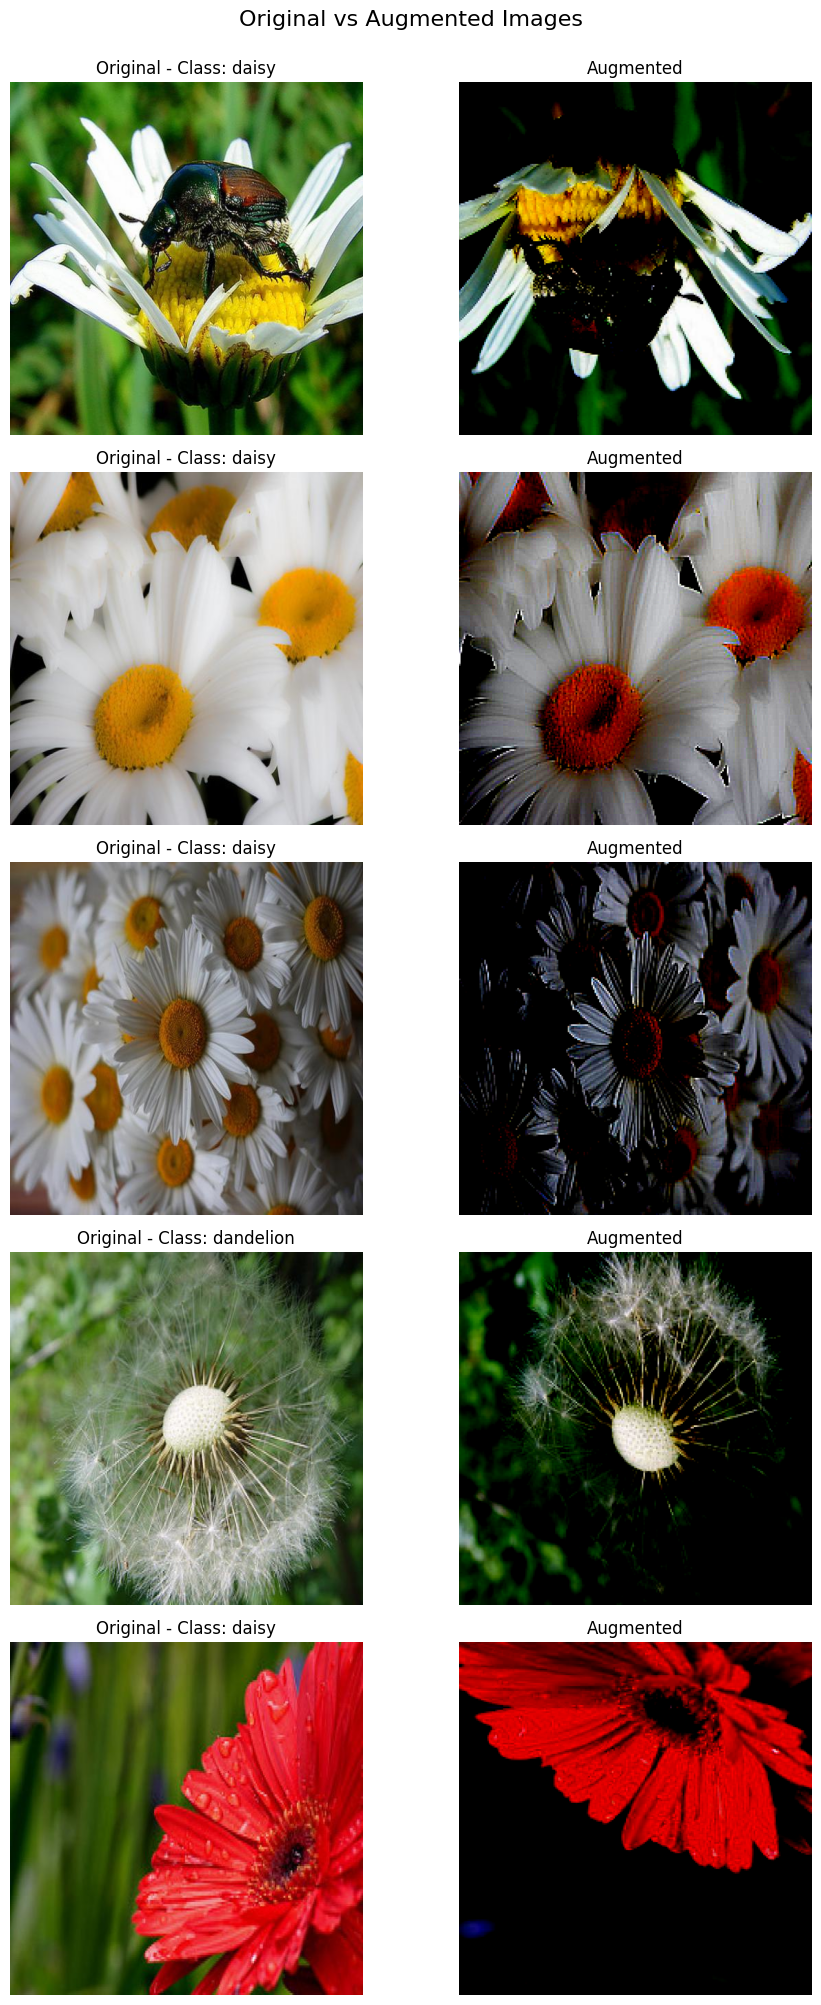

In [8]:
# Visualization of random augmented images from ImageFolder

visualize_augmented_images(trainset_aug, num_images=5)

In [10]:
# Create DataLoader for each dataset split

is_augmented = True
datasets = {
    'train': trainset_aug if is_augmented else trainset,
    'val': valset,
    'test': testset
}

dataloaders = create_data_loaders(datasets, batch_size=BATCH_SIZE, num_workers=0)

train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']

## CNN model: transfer learning with timm

### Preprocessing

In [4]:
# Preprocessing for Transfer Learning Model (with augmentation for train set)
# Resize Dimensions (224,224) and Normalization

trainset_aug, valset, testset = create_datasets(DATA_PATH, augment_train=True)

print('='*60 + "\nTrain:")
print(trainset_aug)
print('='*60 + "\Val:")
print(valset)
print('='*60 + "\Test:")
print(testset)
print("="*60)

Train:
Dataset ImageFolder
    Number of datapoints: 1275
    Root location: dataset/progetto-finale-flowes//train
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x17df3ac10>
============================================================\Val:
Dataset ImageFolder
    Number of datapoints: 364
    Root location: dataset/progetto-finale-flowes//valid
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x29479cb50>
============================================================\Test:
Dataset ImageFolder
    Number of datapoints: 182
    Root location: dataset/progetto-finale-flowes//test
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x29479cb50>


In [5]:
# Create DataLoader for each dataset split

is_augmented = True
datasets = {
    'train': trainset_aug if is_augmented else trainset,
    'val': valset,
    'test': testset
}

dataloaders = create_data_loaders(datasets, batch_size=BATCH_SIZE, num_workers=0)

train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']

### Transfer Learning model creation and training

In [6]:
# Define configurations

num_epochs = 100
learning_rate = 0.001
num_classes = len(trainset_aug.classes)

In [14]:
# Create model with ORIGINAL classifier and freeze layers

logger = get_logger(ch_log_level=logging.INFO, fh_log_level=logging.DEBUG)

model_original = create_model(num_classes=2, model_type='efficientnet_b5.sw_in12k_ft_in1k', use_custom_classifier=False)
#model_original = create_model(num_classes=2, model_type='convnext_base', use_custom_classifier=False)
#model_original = create_model(num_classes=2, model_type='resnet50', use_custom_classifier=False)

model_original.to(device)
optimizer = torch.optim.Adam(model_original.parameters(), lr=learning_rate)

freeze_layers(model_original, num_layers=-1)

model = model_original

In [25]:
# Create model with CUSTOM classifier and freeze layers

logger = get_logger(ch_log_level=logging.INFO, fh_log_level=logging.DEBUG)

model_custom = create_model(num_classes=2, model_type='efficientnet_b5.sw_in12k_ft_in1k', use_custom_classifier=True)
#model_custom = create_model(num_classes=2, model_type='convnext_base', use_custom_classifier=True)
#model_custom = create_model(num_classes=2, model_type='resnet50', use_custom_classifier=True)

model_custom.to(device)
optimizer = torch.optim.Adam(model_custom.parameters(), lr=learning_rate)

freeze_layers(model_custom, num_layers=-1)

model = model_custom

In [ ]:
summary(model, (3,224,224))

In [7]:
# Initialize Experiment

experiment = Experiment("Efficientnet_b5_TL", "experiments")
experiment.init()

In [ ]:
# Training step

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=True),
    ModelCheckpoint(filepath='best_model_transfer_learning_efficientnet_b5.pth', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
]

since = time.time()
trained_model = train_model(model, optimizer, train_loader, val_loader, experiment, callbacks, num_epochs, device, logger)

# To restart from a checkpoint
#trained_model = train_model(model, optimizer, train_loader, val_loader, experiment, callbacks, num_epochs, device, logger, 
#resume_from='models/best_model_baseline.pth')

time_elapsed = time.time() - since
logger.info('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [ ]:
# Plot history

experiment.plot_history()

### Model Evaluation

In [12]:
# Evaluation train and validation results

scatter_plot_metrics('experiments/ResNet_50_custom_TL/history/train.csv', 'experiments/ResNet_50_custom_TL/history/val.csv')

In [8]:
# load model and checkpoint

model = create_model(num_classes=2, model_type='resnet50', use_custom_classifier=False)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
 
full_model = torch.load('models/best_model_transfer_learning_resnet50.pth', map_location=torch.device(device))
checkpoint = torch.load('models/best_model_transfer_learning_resnet50.pth', map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
logs = checkpoint['logs']
best = checkpoint['best']

/var/folders/8d/09j2zdrx7klfl7nffqz630000000gn/T/ipykernel_70189/2965379858.py:7: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/var/folders/8d/09j2zdrx7klfl7nffqz630000000g

In [ ]:
# Evaluation on test set

test_logs = validate(model, test_loader, torch.nn.CrossEntropyLoss(), device)
experiment.save_history('test', **test_logs)
logger.info(f"Test Results: {test_logs}")

In [ ]:
# Generate and plot confusion matrix

y_true, y_pred = get_predictions(trained_model, test_loader, device)
plot_confusion_matrix(y_true, y_pred, classes=trainset_aug.classes)
logger.info("Confusion matrix saved as 'confusion_matrix.png'")

In [9]:
# Replace missing values with 0 in column lr from val.csv and test.csv (TO BE REFACTORED)

val = pd.read_csv("experiments/ResNet_50_TL/history/val.csv")
val['lr'] = val['lr'].fillna(0).to_numpy()
val.to_csv("experiments/ResNet_50_TL/history/val.csv", index=False)

test = pd.read_csv("experiments/ResNet_50_TL/history/test.csv")
test['lr'] = test['lr'].fillna(0).to_numpy()
test.to_csv("experiments/ResNet_50_TL/history/test.csv", index=False)

In [11]:
# Calculate average metrics for last n epochs

experiment = Experiment("ResNet_50_TL", "experiments")
experiment.load_history_from_file("val")
experiment.load_history_from_file("train")
experiment.load_history_from_file("test")

avg_metrics = experiment.calculate_average_metrics('val', last_n_epochs=5)
print("Average validation metrics:", avg_metrics)

Average validation metrics: {'loss': 0.11865897755046466, 'accuracy': 0.9445054945054945, 'precision': 0.9593490064846119, 'recall': 0.9393034825870646, 'f1': 0.9492169977873053, 'lr': 0.0}


In [12]:
# Export results in JSON

experiment.export_results_to_json("experiments/ResNet_50_TL/results/results.json")

In [13]:
# Find best epoch according to validation accuracy 

metric = 'accuracy'

best_epoch = experiment.get_best_epoch(metric, mode='max')
print(f"Best validation accuracy was achieved at epoch {best_epoch} with {100*experiment.history['val'][metric][best_epoch-1]:.1f}%")

Best validation accuracy was achieved at epoch 62 with 95.1%


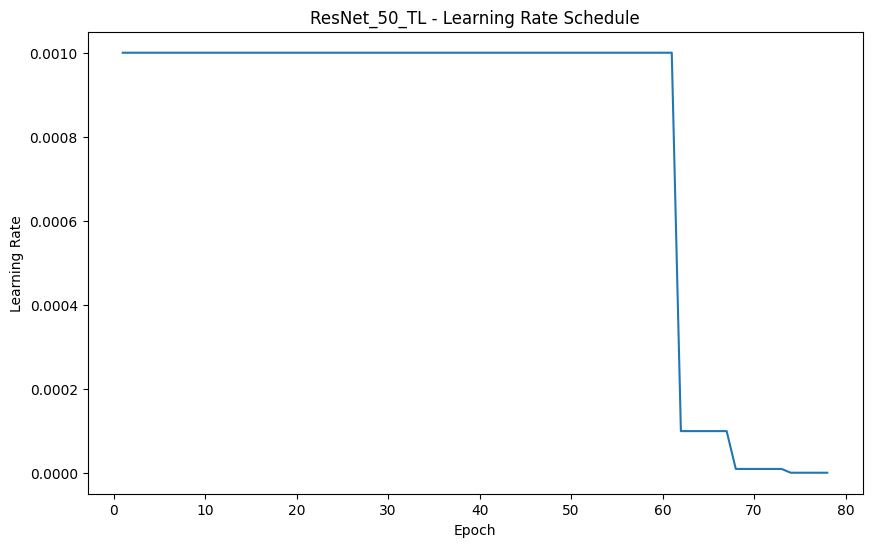

In [14]:
# Plot learning rate

experiment.plot_learning_rate(experiment.history['train']['lr'])

In [ ]:
# Plot misclassified images with ground truth and prediction

plot_misclassified_images(
    model=model,
    dataloader=test_loader,
    device=device,
    num_images=16,
    class_names=trainset_aug.classes,
    mean=(0.5, 0.5, 0.5),
    std=(0.5, 0.5, 0.5)
)

### Interactive Report Dashboard with DataPane

In [ ]:
# load model and checkpoint

model = create_model(num_classes=2, model_type='resnet50', use_custom_classifier=False)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
 
full_model = torch.load('models/best_model_transfer_learning_resnet50.pth', map_location=torch.device(device))
checkpoint = torch.load('models/best_model_transfer_learning_resnet50.pth', map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
logs = checkpoint['logs']
best = checkpoint['best']

In [ ]:
# Interactive Report generator

y_true, y_pred = get_predictions(model, test_loader, device)
train_metrics = pd.read_csv('experiments/ResNet_50_TL/history/train.csv')
val_metrics = pd.read_csv('experiments/ResNet_50_TL/history/val.csv')
test_metrics = pd.read_csv('experiments/ResNet_50_TL/history/test.csv')

generate_interactive_report(
    experiment_name="ResNet_50_TL",
    train_metrics=train_metrics,
    val_metrics=val_metrics,
    test_metrics=test_metrics,
    y_true=y_true,
    y_pred=y_pred,
    class_names=['Daisy', 'Dandelion']
)

## Object Detection with YOLO

### Extract small dataset for object detection

*I used **Roboflow** to create this dataset (images and labels)*

- Project ID: flowers-object-detection-zscwu
- url: https://universe.roboflow.com/silvano-9j4jy/flowers-object-detection-zscwu/dataset/1

In [4]:
# Extract Dataset and save files to dataset folder

extract_dataset('flowers object detection.v1i.yolov11.zip', 'dataset_detection/')

Extracting files: 100%|██████████| 332/332 [00:00<00:00, 8351.38file/s]

Dataset extracted to dataset_detection
Total files extracted: 332
Removing macOS hidden files...
Removed 0 macOS hidden files/folders
Final number of files: 332


### Import libraries for object detection step

In [ ]:
# If you're running this repo on Google Colab

!pip install ultralytics

In [8]:
# import further libraries for object detection

import wandb
wandb.init(mode="disabled")

from ultralytics import YOLO

In [10]:
# set up YOLO model

model = YOLO("yolo11n.pt")

100%|██████████| 5.35M/5.35M [00:00<00:00, 18.7MB/s]


### Set up for data.yaml file

In [ ]:
# add correct path for data.yaml

with open('dataset_detection/data.yaml', 'r') as file:
    content = file.read()

new_content = "path: ../dataset_detection  # dataset root dir\n" + content

with open('dataset_detection/data.yaml', 'w') as file:
    file.write(new_content)

print("Content after modification:")
with open('dataset_detection/data.yaml', 'r') as file:
    print(file.read())

### Training - Validation - Test 

In [ ]:
# Training YOLO model

save_dir = '/content/drive/MyDrive/Project_PyTorch_ProfessionAI/'

model.train(
    data = "dataset_detection/data.yaml",
    project = save_dir,
    epochs = 30,
    patience = 10,
    batch = 16,
    plots = True,
    device = 0
  )

In [ ]:
# Validation settings

validation_results = model.val(
    data = "dataset_detection/data.yaml"
)

In [ ]:
# Inference on test images

images = os.listdir("dataset_detection/test/images")
images = ["dataset_detection/test/images/" + file for file in images]

results_test = model(images)

for idx, result in enumerate(results_test):
    result.save(filename = save_dir + f"result_{idx}.jpg")

### Test results 

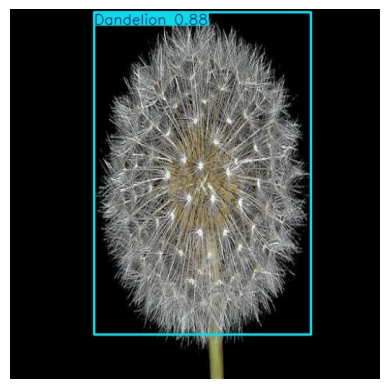

In [24]:
# Plot random image from test resutls

import matplotlib.image as img

random_index = np.random.randint(0, 15)

random_img = img.imread(f"results_from_detection/test_results_img/result_{random_index}.jpg")
plt.imshow(random_img)
plt.axis("off")
plt.show()